# Analysis of 1D embedding neural network

In [6]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import json
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

# sklearn for pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import auc

# ROC AUC
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

# TensorFlow api model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

## Load data

In [7]:
# Data location
data_loc = '../data/10k_training_test/'

# Read in JSON to rename columns
with open("./output/01_feature_name_dict.json") as json_file:
    dict_feature_name = json.load(json_file)

# Read in the names of the selected features for the model
number_of_features_to_use = 10
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# Read data
train_original = pd.read_csv(data_loc + 'cohort_10000_train.csv')
test_original = pd.read_csv(data_loc + 'cohort_10000_test.csv')

# Select features
train_original = train_original[key_features]
test_original = test_original[key_features]

# Rename fields
train_original.rename(columns=dict_feature_name, inplace=True)
test_original.rename(columns=dict_feature_name, inplace=True)

# Get data subgroups
subgroups = pd.read_csv('../data/subnet.csv', index_col='Item')
# Get list of clinical items
clinical_subgroup = subgroups.loc[subgroups['Subnet']=='patient']
clinical_subgroup = list(clinical_subgroup.index)
# Get list of pathway items
pathway_subgroup = subgroups.loc[subgroups['Subnet']=='pathway']
pathway_subgroup = list(pathway_subgroup.index)
# Get list of hospital items
hospital_subgroup = subgroups.loc[subgroups['Subnet']=='team']
hospital_subgroup = list(set(train_original['Stroke team']))
hospital_subgroup.sort()

## Function to scale data (minmax scaling)

In [8]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc    

## Load neural net

In [9]:
# Load model
filename = f'./saved_models/10k_nn.h5'
model = keras.models.load_model(filename)

In [10]:
# Copy original data
train = train_original.copy(deep=True)
test = test_original.copy(deep=True)

# OneHot encode stroke team
coded = pd.get_dummies(train['Stroke team'])
train = pd.concat([train, coded], axis=1)
train.drop('Stroke team', inplace=True, axis=1)
coded = pd.get_dummies(test['Stroke team'])
test = pd.concat([test, coded], axis=1)
test.drop('Stroke team', inplace=True, axis=1)

# Split into X, y
X_train_df = train.drop('Thrombolysis',axis=1) 
y_train_df = train['Thrombolysis']
X_test_df = test.drop('Thrombolysis',axis=1) 
y_test_df = test['Thrombolysis'] 

# Split train and test data by subgroups
X_train_patients = X_train_df[clinical_subgroup]
X_test_patients = X_test_df[clinical_subgroup]
X_train_pathway = X_train_df[pathway_subgroup]
X_test_pathway = X_test_df[pathway_subgroup]
X_train_hospitals = X_train_df[hospital_subgroup]
X_test_hospitals = X_test_df[hospital_subgroup]

# Convert to NumPy
X_train = X_train_df.values
X_test = X_test_df.values
y_train = y_train_df.values
y_test = y_test_df.values

# Scale data
X_train_patients_sc, X_test_patients_sc = \
    scale_data(X_train_patients, X_test_patients)

X_train_pathway_sc, X_test_pathway_sc = \
    scale_data(X_train_pathway, X_test_pathway)

X_train_hospitals_sc, X_test_hospitals_sc = \
    scale_data(X_train_hospitals, X_test_hospitals)

### Test model
probability = model.predict(
    [X_train_patients_sc, X_train_pathway_sc, X_train_hospitals_sc])
y_pred_train = probability >= 0.5
y_pred_train = y_pred_train.flatten()
accuracy_train = np.mean(y_pred_train == y_train)
print(f'Accuracy train {accuracy_train:0.3f}')

probability = model.predict(
    [X_test_patients_sc, X_test_pathway_sc, X_test_hospitals_sc])
y_pred_test = probability >= 0.5
y_pred_test = y_pred_test.flatten()
accuracy_test = np.mean(y_pred_test == y_test)
print(f'Accuracy test {accuracy_test:0.3f}')

prob_df = pd.DataFrame(probability, columns=['predicted_probability'])
prob_df.to_csv('./output/61_nn_10k_prediction_probs.csv', index=False)

2023-03-29 07:15:31.427130: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-03-29 07:15:31.427440: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz
2023-03-29 07:15:31.498018: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Accuracy train 0.843
Accuracy test 0.840


## Calculate ROC AUC

In [11]:
probability = model.predict(
    [X_test_patients_sc, X_test_pathway_sc, X_test_hospitals_sc])
fpr, tpr, thresholds = roc_curve(y_test, probability)
roc_auc = auc(fpr, tpr)
print (f'AUC: {roc_auc:0.4f}')

AUC: 0.9054


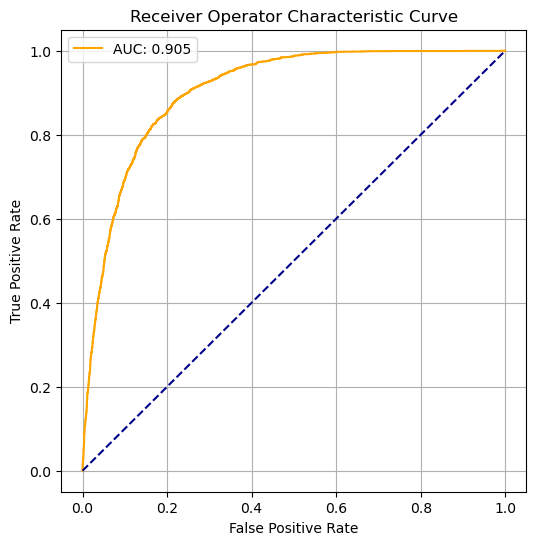

In [12]:
fig = plt.figure(figsize=(6,6))

# Plot ROC
ax1 = fig.add_subplot()
ax1.plot(fpr, tpr, color='orange', label=f'AUC: {roc_auc:0.3f}')
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic Curve')
plt.grid(True)
plt.legend()
plt.show()

## Get predictions for thrombolysis use of 10k set of patients at each hospital

Here we ask the counter-factual question - "what treatment would a patient be expected to receive at each of the 132 hospitals?".

Hospital is one-hot encoded as input to the hospital subnet. To make a prediction of treatment at different hospitals we change the one-hot encoding of the hospital when making prediction.

For each hospital we pass through the 10k test set, and record the proportion of the patients receiving thrombolysis at that hospital.

In [13]:
# Get number of hospitals
num_hospitals = len(X_test_hospitals_sc[0])
# Create test array for changing hospital ID
X_hospitals_alter = X_test_hospitals_sc.copy()
# Get classification for all patients at all hospitals
patient_results = []

# Loop through setting hospital
hospital_results = []
for hosp in range(num_hospitals):
    # Set all hospitals to zero
    X_hospitals_alter[:,:] = 0
    # Set test hospital to 1
    X_hospitals_alter[:,hosp] = 1
    # Get probability of thrombolysis
    probability = model.predict(
        [X_test_patients_sc, X_test_pathway_sc, X_hospitals_alter])
    # Classify
    classified = probability >= 0.5
    patient_results.append(classified)
    # Get average thrombolysis (we are not stroring all individual results)
    thrombolysis = classified.mean()
    hospital_results.append(thrombolysis)

# Put results in DataFrame 
predicted_thrombolysis = pd.DataFrame()
predicted_thrombolysis['hospital'] = hospital_subgroup
predicted_thrombolysis['10k_thrombolysis'] = hospital_results

# Show DataFrame
predicted_thrombolysis

KeyboardInterrupt: 

## Comparing hospital subnet activation with actual thrombolysis use and predicted thrombolysis use in 10k set of patients attending each hospital

The hospital subnet outputs a single value (in the range 0-1) for each hospital.

Here we compare the hospital subnet output for each hospital with:

1. The actual use of thrombolysis for 10k test-set patients at their own hospital only.

2. The expected use of thrombolysis in the 10k test-set for each hospital. The 10k patient data set is passed through all hospital models (by changing the one-hot hospital encoding).

### Get hospital subnet output

This code gets the output directly from the hospital subnet in the neural network. We add this to our results DataFrame.

In [ ]:
results = []
for hosp in range(num_hospitals):
    # Set all hospitals to zero
    X_hospitals_alter[:,:] = 0
    # Set test hospital to 1
    X_hospitals_alter[:,hosp] = 1
    # Get hospital subnet output
    layer_name = 'hospital_encode'
    hospital_encode_model = keras.Model(
        inputs=model.input,outputs=model.get_layer(layer_name).output)
    hospital_encode_output = hospital_encode_model([
        X_test_patients_sc, X_test_pathway_sc, X_hospitals_alter])
    results.append(np.mean(hospital_encode_output.numpy().flatten()))
    
# Add to DataFrame
predicted_thrombolysis['hosp_subnet_output'] = results

### Add actual thrombolysis at hospitals in 10k test set

In [ ]:
actual_thrombolysis = test_original.groupby('Stroke team').mean()['Thrombolysis']
# Add to DataFrame
predicted_thrombolysis['actual_thrombolysis'] = actual_thrombolysis.values

In [ ]:
predicted_thrombolysis.to_csv('./output/61_nn_10k_hospital_output.csv', index=False)
predicted_thrombolysis

### Show relationship between subnet output and predicted thrombolysis use in the 10k patient set

Here we plot the relationship between the hospital subnet output for each hospital and 1) actual thrombolysis use in the test set at each hospital, the predicted thrombolysis use of the whole 10k patient set attended each hospital.

In [ ]:
# Set up figure
fig = plt.figure(figsize=(10,6))

# Plot 1: actual vs subnet

correlation = predicted_thrombolysis.corr()
r_square_model = \
    correlation['hosp_subnet_output']['actual_thrombolysis'] ** 2
label_text = f'R-squared: {r_square_model:0.3f}'

ax1 = fig.add_subplot(121)
ax1.scatter(predicted_thrombolysis['hosp_subnet_output'],
           predicted_thrombolysis['actual_thrombolysis'], label=label_text)
ax1.set_xlabel('Hospital subnet activation')
ax1.set_ylabel('Thrombolysis use (actual)')
ax1.set_ylim(0,0.5)
ax1.set_title('Actual thrombolysis vs.\nhospital subnet output')
ax1.legend()
ax1.grid()

# Plot 2: 10k vs subnet

correlation = predicted_thrombolysis.corr()
r_square_model = \
    correlation['hosp_subnet_output']['10k_thrombolysis'] ** 2
label_text = f'R-squared: {r_square_model:0.3f}'

ax2 = fig.add_subplot(122)
ax2.scatter(predicted_thrombolysis['hosp_subnet_output'],
           predicted_thrombolysis['10k_thrombolysis'], label=label_text)
ax2.set_xlabel('Hospital subnet activation')
ax2.set_ylabel('Thrombolysis use (reference set)')
ax2.set_ylim(0,0.5)
ax2.set_title('Predicted 10k thrombolysis vs.\nhospital subnet output')
ax2.legend()
ax2.grid()

plt.tight_layout(pad=2)
plt.show()

## Examine clinical subnet output

In this section we examine the output of the clinical subnet. This subnet is patient-specific, but excludes pathway data (such as day/time of arrival, time since stroke, time of scan, etc).The output is therefore dependent on patient clinical characteristics, but is not dependent on which hospital a patient attended or dependent on pathway data.

### Get clincial subnet output for 10k patients

This code gets the output directly from the clinical subnet in the neural network. We store this with all patient characteristics (the loaded test set data).

In [ ]:
# Get patient subnet output
layer_name = 'patient_encode'
patient_encode_model = keras.Model(
    inputs=model.input,outputs=model.get_layer(layer_name).output)
patient_encode_output = patient_encode_model([
    X_test_patients_sc, X_test_pathway_sc, X_test_hospitals_sc])

# Put in DataFrame with all patient characteristics (X)
clinical_subnet_output = test.copy()
clinical_subnet_output['patient_subnet_output'] = \
    patient_encode_output.numpy().flatten()

clinical_subnet_output['num_hosp_thrombolysising'] = \
    np.sum(patient_results, axis=0).flatten()

# Sort by patient_subnet_output
clinical_subnet_output.sort_values('patient_subnet_output', inplace=True)

### Show relationship between clinical subnet output and proportion of patients receiving thrombolysis

Here we test the relationship between the output of the clinical subnet and the actual use of thrombolysis. We do this by binning the output of the clinical subnets into 10 bins (each representing a range of 0.1 in the clinical subnet output), and taking the average use of thrombolysis in that bin.

In [ ]:
subnet_values = clinical_subnet_output['patient_subnet_output'].values
subnet_values = subnet_values * 10
clinical_subnet_output['subnet_bin'] = subnet_values.astype(int)/10 + 0.05


rx = clinical_subnet_output.groupby('subnet_bin').mean()['Thrombolysis']
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(rx.index, rx.values)
ax.set_xlabel('Clinical subnet output (binned)')
ax.set_xlim(0,1)
ax.set_ylabel('Proportion of patients receiving thrombolysis')
plt.show()

In [ ]:
clinical_subnet_output.sort_index(inplace=True)
clinical_subnet_output.head()
clinical_subnet_output.to_csv('./output/61_nn_10k_patient_embedding_output.csv', index=False)